In [2]:
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
normal_activation=torch.load(f"./llama2/intervene/stored_activation/dolly_llama7b.pt")

/tmp/ipykernel_3038312/326363204.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  normal_activation=torch.load(f"./llama2/intervene/stored_activation/dolly_llama7b.pt")


In [3]:
print(normal_activation[0].shape)

torch.Size([300, 4096])


In [4]:

import torch
import numpy as np
from sklearn.cross_decomposition import CCA

def svcca(
    X,
    Y,
    svd_indices=None,
    n_svd_components=None,
    n_cca_components=None,
    threshold=1e-6,
    device='cuda:0'
):
    
    if X.dtype == torch.bfloat16:
        X = X.to(dtype=torch.float32)
    if Y.dtype == torch.bfloat16:
        Y = Y.to(dtype=torch.float32)

    X = X.to(device, non_blocking=True)
    Y = Y.to(device, non_blocking=True)


    X_mean = X.mean(dim=0, keepdim=True)
    Y_mean = Y.mean(dim=0, keepdim=True)
    X_centered = X - X_mean
    Y_centered = Y - Y_mean

    Ux, Sx, Vx = torch.linalg.svd(X_centered, full_matrices=False)
    Uy, Sy, Vy = torch.linalg.svd(Y_centered, full_matrices=False)


    n_cca_components = len(svd_indices)


    Ux_sel = Ux[:, svd_indices]
    Uy_sel = Uy[:, svd_indices]
    Sx_sel = Sx[svd_indices]
    Sy_sel = Sy[svd_indices]
    Vx_sel = Vx[:, svd_indices]
    Vy_sel = Vy[:, svd_indices]


    X_proj = Ux_sel * Sx_sel  
    Y_proj = Uy_sel * Sy_sel 
    # X_proj = Sx_sel *Vx_sel
    # Y_proj = Sy_sel *Vy_sel



    X_np = X_proj.detach().cpu().numpy()
    Y_np = Y_proj.detach().cpu().numpy()


    cca = CCA(n_components=n_cca_components)
    cca.fit(X_np, Y_np)

    X_c, Y_c = cca.transform(X_np, Y_np)  # shape [N, n_cca_components]
    X_c_torch = torch.from_numpy(X_c).to(device)
    Y_c_torch = torch.from_numpy(Y_c).to(device)

    corrs = []

    for i in range(n_cca_components):
        # Stack the two canonical components for correlation
        comp = torch.stack([X_c_torch[:, i], Y_c_torch[:, i]], dim=0)
        corr = torch.corrcoef(comp)[0, 1].item()
   
        corrs.append(corr)
    return corrs

In [7]:
import numpy as np
#to ignore the warning here
import warnings
warnings.filterwarnings("ignore")
svcca_similarities = []
similarity=[]

idx_list=list(range(3))


def analyze_layer_eigenvalues(normal_activation, idx_list):

    svcca_similarities = []
    
    # Analyze each layer
    for idx in range(2,len(normal_activation)-2):
    # Compare each layer's representations between normal and initial activations
        sim_forward1 = svcca(normal_activation[idx],
                            normal_activation[idx + 1],
                            svd_indices=idx_list)
        sim_backward1 = svcca(normal_activation[idx],
                            normal_activation[idx - 1],
                            svd_indices=idx_list)
        sim_forward2 = svcca(normal_activation[idx],
                            normal_activation[idx + 2],
                            svd_indices=idx_list)
        sim_backward2 = svcca(normal_activation[idx],
                            normal_activation[idx - 2],
                            svd_indices=idx_list)

        combined_similarity = sim_forward1.copy()
        combined_similarity.extend(sim_backward1)
        combined_similarity.extend(sim_backward2)
        combined_similarity.extend(sim_forward2)
        
        svcca_similarities.append(combined_similarity)
    
    # Plot overall SVCCA similarities
    res_svcca_similarities = [np.mean(item) for item in svcca_similarities]
    
    return res_svcca_similarities

# Example usage:
svcca_results_1 = analyze_layer_eigenvalues(normal_activation,  idx_list=list(range(1)))
svcca_results_2 = analyze_layer_eigenvalues(normal_activation, idx_list=list(range(3)))
svcca_results_3 = analyze_layer_eigenvalues(normal_activation,  idx_list=list(range(10)))


In [8]:
import numpy as np
import torch
res=torch.load("./llama2/model_cka/Llama-2-7b-chat-hf/dolly_linear_cka.pt")
print(res.shape)

def calculate_all_diagonal_window_means(matrix: torch.Tensor, window_size: int) -> torch.Tensor:
   
    assert matrix.dim() == 2, "Input matrix must be 2D"
    assert window_size > 0, "Window size must be a positive integer"
    
    diagonal_means = torch.zeros(matrix.shape[1], dtype=torch.float32)
    
    # Loop over each column to calculate the mean of diagonal elements
    for col_index in range(matrix.shape[1]):
        half_window = window_size // 2
        start_row = max(0, col_index - half_window)
        end_row = min(matrix.shape[0], col_index + half_window + 1)
        
        # Extract diagonal elements
        diagonal_values = [matrix[row, col_index] for row in range(start_row, end_row) if 0 <= row < matrix.shape[0]]
        
        if len(diagonal_values) > 0:
            diagonal_mean = torch.mean(torch.tensor(diagonal_values, dtype=torch.float32))
        else:
            diagonal_mean = 0.0  # If no elements are found, default to 0
        
        diagonal_means[col_index] = diagonal_mean
    
    return diagonal_means


torch.Size([32, 32])


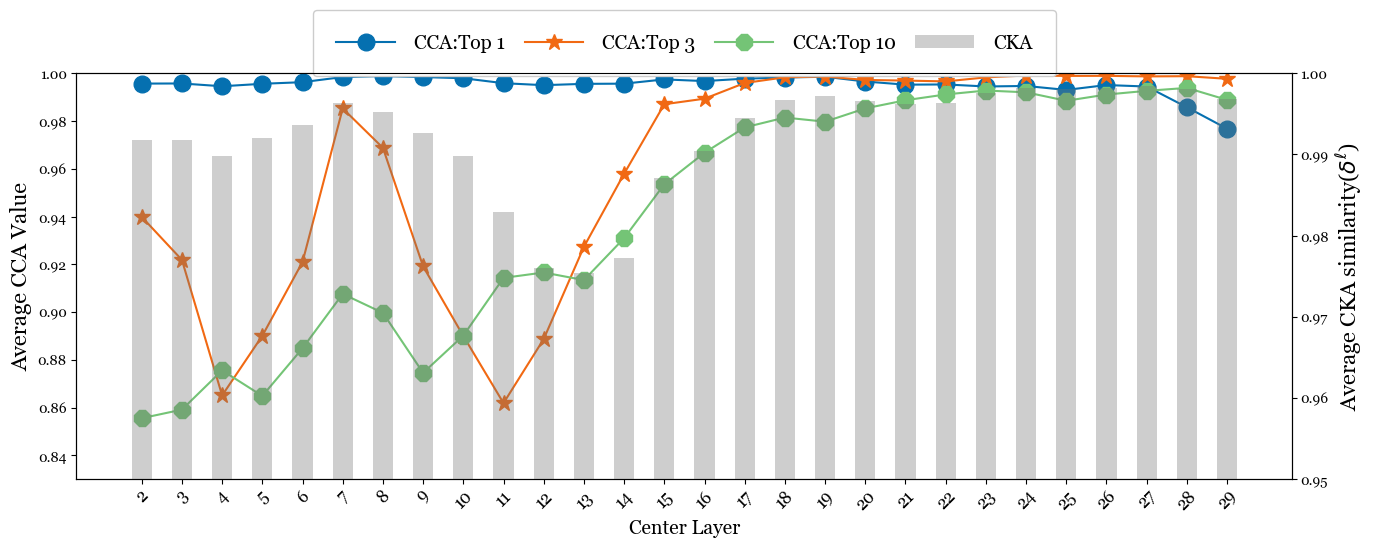

In [9]:
import matplotlib.pyplot as plt
import numpy as np

colors = ['#0570b0', '#f16913', '#74c476', '#abd9e9', '#2c7bb6']
plt.rcParams.update({'font.family': 'Georgia'})

n = len(svcca_results_1)
result1 = calculate_all_diagonal_window_means(res, 5).numpy()[2:-2]
indices = np.arange(2, n + 2)

fig, ax1 = plt.subplots(figsize=(16, 5.8))
ax2 = ax1.twinx()

line1, = ax1.plot(indices, svcca_results_1, marker='o', markersize=12, linestyle='-', color=colors[0], label='Top 1')
line2, = ax1.plot(indices, svcca_results_2, marker='*', markersize=12, linestyle='-', color=colors[1], label='Top 3')
line3, = ax1.plot(indices, svcca_results_3, marker='8', markersize=12, linestyle='-', color=colors[2], label='Top 10')

ax1.set_xlabel("Center Layer", fontsize=14)
ax1.set_ylabel("Average CCA Value", fontsize=16)
ax1.set_xticks(indices)
ax1.set_xticklabels(indices, fontsize=12, rotation=45)
ax1.tick_params(axis='x', pad=2)
# Increase the top margin of the left y-axis so values near 1 are not cramped.
ax1.set_ylim(0.83, 1.00)

bar_width = 0.5
bar_container = ax2.bar(indices, result1, width=bar_width, color='#737373',
                        alpha=0.35, label='CKA', align='center')
ax2.set_ylabel(r'Average CKA similarity($\delta^{\ell}$)', fontsize=16)

ax2.set_ylim(0.95, 1.00)
ax2.tick_params(axis='y', pad=2)

lines = [line1, line2, line3, bar_container[0]]
labels = ['CCA:Top 1', 'CCA:Top 3', 'CCA:Top 10', 'CKA']

ax1.legend(lines, labels,
           loc='upper center',
           bbox_to_anchor=(0.5, 1.18),  
           ncol=4,
           fontsize=18,  
           markerscale=1.0,  
           handlelength=3,  
           handletextpad=1.0, 
           borderpad=1.21,     
           labelspacing=1.0,   
           columnspacing=1.0,  
           frameon=True,       
           framealpha=1,    # Make frame more opaque
           prop={'family': 'Georgia', 'size': 14})  

plt.subplots_adjust(left=0.12, right=0.88, top=0.80, bottom=0.10)

plt.savefig('svcca.pdf',
            format='pdf',
            bbox_inches='tight',
            pad_inches=0.3)  

plt.show()